In [11]:
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn

In [12]:
# Adapted from https://github.com/OpenFreeEnergy/cinnabar/blob/26eecb75bdbb5d7baf8798615feed16effe62abb/cinnabar/stats.py#L8

def bootstrap_statistic(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dy_true: Union[np.ndarray, None] = None,
    dy_pred: Union[np.ndarray, None] = None,
    ci: float = 0.95,
    statistic: str = "RMSE",
    nbootstrap: int = 100,
    plot_type: str = "dG",
    include_true_uncertainty: bool = False,
    include_pred_uncertainty: bool = False,
) -> dict:
    """
    Compute mean and confidence intervals of specified statistic.

    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    dy_true : ndarray with shape (N,) or None
        Errors of true values. If None, the values are assumed to have no errors
    dy_pred : ndarray with shape (N,) or None
        Errors of predicted values. If None, the values are assumed to have no errors
    ci : float, optional, default=0.95
        Interval for confidence interval (CI)
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'
    include_true_uncertainty : bool, default False
        whether to account for the uncertainty in y_true when bootstrapping
    include_pred_uncertainty : bool, default False
        whether to account for the uncertainty in y_pred when bootstrapping

    Returns
    -------
    rmse_stats : dict of float
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """

    def compute_statistic(
        y_true_sample: np.ndarray, y_pred_sample: np.ndarray, statistic: str
    ):
        """Compute requested statistic.

        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho','RAE','KTAU']

        """

        def calc_RAE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            MAE = sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
            mean = np.mean(y_true_sample)
            MAD = np.sum([np.abs(mean - i) for i in y_true_sample]) / float(
                len(y_true_sample)
            )
            return MAE / MAD

        def calc_RRMSE(y_true_sample: np.ndarray, y_pred_sample: np.ndarray):
            rmse = np.sqrt(
                sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample)
            )
            mean_exp = np.mean(y_true_sample)
            mds = np.sum([(mean_exp - i) ** 2 for i in y_true_sample]) / float(
                len(y_true_sample)
            )
            rrmse = np.sqrt(rmse**2 / mds)
            return rrmse

        if statistic == "RMSE":
            return np.sqrt(
                sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample)
            )
        elif statistic == "MUE":
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == "MSE":
            # mean signed error
            return np.mean(y_pred_sample - y_true_sample)
        elif statistic == "R2":
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
                y_true_sample, y_pred_sample
            )
            return r_value**2
        elif statistic == "rho":
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        elif statistic == "RAE":
            return calc_RAE(y_true_sample, y_pred_sample)
        elif statistic == "KTAU":
            return scipy.stats.kendalltau(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))

    # not used?
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array([(x[i] - x[j]) for i in range(N) for j in range(N) if (i != j)])

    if dy_true is None:
        dy_true = np.zeros_like(y_true)
    if dy_pred is None:
        dy_pred = np.zeros_like(y_pred)
    assert len(y_true) == len(y_pred)
    assert len(y_true) == len(dy_true)
    assert len(y_true) == len(dy_pred)
    sample_size = len(y_true)
    s_n = np.zeros(
        [nbootstrap], np.float64
    )  # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        y_true_sample = np.zeros_like(y_true)
        y_pred_sample = np.zeros_like(y_pred)
        for i, j in enumerate(
            np.random.choice(np.arange(sample_size), size=[sample_size], replace=True)
        ):
            stddev_true = np.fabs(dy_true[j]) if include_true_uncertainty else 0
            stddev_pred = np.fabs(dy_pred[j]) if include_pred_uncertainty else 0
            y_true_sample[i] = np.random.normal(
                loc=y_true[j], scale=stddev_true, size=1
            )
            y_pred_sample[i] = np.random.normal(
                loc=y_pred[j], scale=stddev_pred, size=1
            )
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)

    rmse_stats = dict()
    rmse_stats["mle"] = compute_statistic(y_true, y_pred, statistic)
    rmse_stats["stderr"] = np.std(s_n)
    rmse_stats["mean"] = np.mean(s_n)
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0 - ci) / 2.0
    high_frac = 1.0 - low_frac
    rmse_stats["low"] = s_n[int(np.floor(nbootstrap * low_frac))]
    rmse_stats["high"] = s_n[int(np.ceil(nbootstrap * high_frac))]

    return rmse_stats

In [13]:
pd.ExcelFile("../../../data/final_paper.xlsx").sheet_names

['OLD-TRAIN-DS-DIELECTRIC',
 'OLD-TRAIN-DS-EMLE-SPECIES',
 'OLD-TRAIN-DS-EMLE-REFERENCE',
 'TRAIN-DS-DIELECTRIC',
 'TRAIN-DS-EMLE-SPECIES',
 'TRAIN-DS-MMVACUUMME',
 'TEST-DS-MMVACUUMME',
 'TEST-DS-EMLE-SPECIES',
 'TRANSFERABLE-DATASET-KAR']

In [14]:
df_emle = pd.read_excel(
    "../../../data/final_paper.xlsx", sheet_name="TRAIN-DS-EMLE-SPECIES", header=1
)
df_emle

,Molecule,MM FFs,ML potential,QM7-Species-Rep1,QM7-Species-Rep2,QM7-Species-Rep3,Bespoke-Iter1-Species-Rep1,Bespoke-Iter1-Species-Rep2,Bespoke-Iter1-Species-Rep3,Bespoke-Iter2-Species-Rep1,Bespoke-Iter2-Species-Rep2,Bespoke-Iter2-Species-Rep3,Patched-Iter1-Species-Rep1,Patched-Iter1-Species-Rep2,Patched-Iter1-Species-Rep3,Patched-Iter2-Species-Rep1,Patched-Iter2-Species-Rep2,Patched-Iter2-Species-Rep3
0,n-pentane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1624.275111,-1624.259953,-1624.175950,-1624.026516,-1624.055813,-1624.011538,-1624.016641,-1624.030133,-1624.034849,-1624.196429,-1624.178957,-1624.175535,-1624.134049,-1624.188885,-1624.130743
1,n-octane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-2526.630640,-2526.570872,-2526.678427,-2526.322911,-2526.381230,-2526.324979,-2526.337098,-2526.287208,-2526.305736,-2526.604477,-2526.507374,-2526.539489,-2526.360627,-2526.470535,-2526.461490
2,benzene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1390.557711,-1390.547940,-1390.553603,-1391.141469,-1391.158267,-1391.150607,-1391.125731,-1391.107100,-1391.134763,-1390.974971,-1390.959869,-1390.950488,-1390.963266,-1390.968267,-1390.952082
3,naphthalene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-2196.760893,-2196.772049,-2196.764521,-2197.297069,-2197.298737,-2197.333308,-2197.235215,-2197.323332,-2197.274913,-2196.798581,-2196.913699,-2196.862137,-2196.945848,-2196.909288,-2196.921366
4,water,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-229.247077,-229.245901,-229.206852,-235.566955,-235.508145,-235.545300,-235.548807,-235.652563,-235.622756,-233.776616,-233.763469,-233.786332,-233.443507,-233.479310,-233.450474
5,methanol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-524.710608,-524.661516,-524.715409,-523.187193,-523.200196,-523.187782,-523.198046,-523.162558,-523.164381,-523.042790,-523.019465,-522.993039,-522.752428,-522.760594,-522.783525
6,o-cresol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1782.605859,-1782.661467,-1782.644295,-1781.788087,-1781.861962,-1781.862690,-1781.687859,-1781.662460,-1781.715538,-1781.447752,-1781.415159,-1781.404154,-1781.395446,-1781.408047,-1781.364657
7,aceticacid,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-768.699410,-768.716194,-768.775845,-764.158745,-764.124942,-764.386251,-764.027512,-764.215695,-764.065601,-763.344982,-763.513881,-763.299970,-763.323773,-763.129101,-763.292163
8,1_4-dioxane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1395.548825,-1395.536641,-1395.539808,-1395.148823,-1395.060153,-1395.165467,-1395.210247,-1395.406860,-1395.172516,-1396.201101,-1396.131315,-1396.142635,-1395.978985,-1396.015533,-1395.998857
9,methylpentanoate,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-1990.082001,-1990.102670,-1990.018952,-1989.092661,-1989.053007,-1989.081230,-1989.024545,-1988.852033,-1988.967059,-1987.915386,-1987.899265,-1987.973719,-1987.675664,-1987.644800,-1987.592904


In [15]:
df = pd.read_excel(
    "../../../data/final_paper.xlsx", sheet_name="TRAIN-DS-MMVACUUMME", header=1
)
df

,Molecule,MM FFs,ML potential,MM-Rep1,MM-Rep2,MM-Rep3,Vacuum-Rep1,Vacuum-Rep2,Vacuum-Rep3,ME-Rep1,ME-Rep2,ME-Rep3,Unnamed: 12
0,n-pentane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),2.724395,2.771186,2.668807,-1622.703454,-1622.722110,-1622.731169,-1622.716549,-1622.729876,-1622.667858,0.032646
1,n-octane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),3.094562,3.089491,3.152947,-2524.292917,-2524.274100,-2524.300537,-2524.285710,-2524.366838,-2524.381999,0.051774
2,benzene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-0.915510,-0.955145,-1.041780,-1390.125924,-1390.123216,-1390.119034,-1390.181885,-1390.163951,-1390.156994,0.012842
3,naphthalene,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.568862,-3.558796,-3.510536,-2196.969381,-2196.948231,-2196.950548,-2196.959261,-2196.914793,-2196.938929,0.022261
4,water,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-6.415669,-6.386042,-6.398134,-231.619755,-231.619789,-231.614161,-232.068548,-232.053581,-232.058900,0.007587
5,methanol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.887195,-3.904854,-3.911495,-520.366858,-520.371289,-520.355546,-520.207448,-520.203285,-520.209332,0.003094
6,o-cresol,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-5.350394,-5.361286,-5.404287,-1778.872888,-1778.888010,-1778.891090,-1780.113372,-1780.113372,-1780.046364,0.038687
7,aceticacid,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-6.974250,-6.883560,-6.922687,-760.663608,-760.674895,-760.657271,-760.657452,-760.554795,-760.588866,0.052287
8,1_4-dioxane,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.897217,-3.877977,-3.841539,-1393.933804,-1393.972628,-1393.940700,-1393.872692,-1393.886404,-1393.871344,0.008333
9,methylpentanoate,OpenFF-2.0.0/TIP3P,MACE-OFF23(S),-3.095711,-3.137685,-3.056337,-1986.210272,-1986.206271,-1986.219876,-1986.186428,-1986.144141,-1986.144141,0.024414


In [16]:
# Define the datasets
QM7_COLS = ["QM7-Species-Rep1", "QM7-Species-Rep2", "QM7-Species-Rep3"]
BESPOKE_ITER_1_COLS = [
    "Bespoke-Iter1-Species-Rep1",
    "Bespoke-Iter1-Species-Rep2",
    "Bespoke-Iter1-Species-Rep3",
]
BESPOKE_ITER_2_COLS = [
    "Bespoke-Iter2-Species-Rep1",
    "Bespoke-Iter2-Species-Rep2",
    "Bespoke-Iter2-Species-Rep3",
]
PATCHED_ITER_1_COLS = [
    "Patched-Iter1-Species-Rep1",
    "Patched-Iter1-Species-Rep2",
    "Patched-Iter1-Species-Rep3",
]
PATCHED_ITER_2_COLS = [
    "Patched-Iter2-Species-Rep1",
    "Patched-Iter2-Species-Rep2",
    "Patched-Iter2-Species-Rep3",
]
MM_COLS = ["MM-Rep1", "MM-Rep2", "MM-Rep3"]
VACUUM_COLS = ["Vacuum-Rep1", "Vacuum-Rep2", "Vacuum-Rep3"]
ME_COLS = ["ME-Rep1", "ME-Rep2", "ME-Rep3"]

EXP_MEAN = [
    2.33,
    2.89,
    -0.87,
    -2.39,
    -6.31,
    -5.11,
    -5.87,
    -6.7,
    -5.05,
    -2.57,
    -3.91,
    -3.53,
    -2.22,
    -9.51,
    -3.89,
    -4.7,
    -5.49,
    -10.9,
    -1.05,
    -2.73,
]

# 0.2 kcal/mol according to: https://comp.chem.umn.edu/mnsol/MNSol-v2012_Manual.pdf
EXP_STD = [0.2] * len(EXP_MEAN)

# Get the data for each dataset
MM = df[MM_COLS]
VACUUM = df[VACUUM_COLS]
ME = df[ME_COLS]

QM7 = df_emle[QM7_COLS]
BESPOKE_ITER_1 = df_emle[BESPOKE_ITER_1_COLS]
BESPOKE_ITER_2 = df_emle[BESPOKE_ITER_2_COLS]
PATCHED_ITER_1 = df_emle[PATCHED_ITER_1_COLS]
PATCHED_ITER_2 = df_emle[PATCHED_ITER_2_COLS]

In [17]:
# <dG>
dG_MM_MEAN = MM.mean(axis=1)
dG_ME_MEAN = MM.mean(axis=1) + ME.mean(axis=1) - VACUUM.mean(axis=1)
dG_QM7_MEAN = MM.mean(axis=1) + QM7.mean(axis=1) - VACUUM.mean(axis=1)
dG_BESPOKE_ITER_1_MEAN = (
    MM.mean(axis=1) + BESPOKE_ITER_1.mean(axis=1) - VACUUM.mean(axis=1)
)
dG_BESPOKE_ITER_2_MEAN = (
    MM.mean(axis=1) + BESPOKE_ITER_2.mean(axis=1) - VACUUM.mean(axis=1)
)
dG_PATCHED_ITER_1_MEAN = (
    MM.mean(axis=1) + PATCHED_ITER_1.mean(axis=1) - VACUUM.mean(axis=1)
)
dG_PATCHED_ITER_2_MEAN = (
    MM.mean(axis=1) + PATCHED_ITER_2.mean(axis=1) - VACUUM.mean(axis=1)
)

# Uncertainty (propag)
dG_MM_STD = MM.std(axis=1)
dG_ME_STD = np.sqrt(MM.std(axis=1) ** 2 + ME.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2)
dG_QM7_STD = np.sqrt(
    MM.std(axis=1) ** 2 + QM7.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)
dG_BESPOKE_ITER_1_STD = np.sqrt(
    MM.std(axis=1) ** 2 + BESPOKE_ITER_1.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)
dG_BESPOKE_ITER_2_STD = np.sqrt(
    MM.std(axis=1) ** 2 + BESPOKE_ITER_2.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)
dG_PATCHED_ITER_1_STD = np.sqrt(
    MM.std(axis=1) ** 2 + PATCHED_ITER_1.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)
dG_PATCHED_ITER_2_STD = np.sqrt(
    MM.std(axis=1) ** 2 + PATCHED_ITER_2.std(axis=1) ** 2 + VACUUM.std(axis=1) ** 2
)

# Sample std error : t_student_coeff * std / sqrt(3)
t_student_coeff = 4.303 #2.920   
dG_MM_ERROR = t_student_coeff * dG_MM_STD / np.sqrt(3)
dG_ME_ERROR = t_student_coeff * dG_ME_STD / np.sqrt(3)
dG_QM7_ERROR = t_student_coeff * dG_QM7_STD / np.sqrt(3)
dG_BESPOKE_ITER_2_ERROR = t_student_coeff * dG_BESPOKE_ITER_2_STD / np.sqrt(3)
dG_PATCHED_ITER_2_ERROR = t_student_coeff * dG_PATCHED_ITER_2_STD / np.sqrt(3)

# Create a dataframe with the data
df_data_mean = pd.DataFrame(
    {
        "EXP": EXP_MEAN,
        "OpenFF/TIP3P": dG_MM_MEAN,
        #"ML/MM (MM Embedding)": dG_ME_MEAN,
        "General Model": dG_QM7_MEAN,
        #'BESPOKE_ITER_1': dG_BESPOKE_ITER_1_MEAN,
        "Bespoke Model": dG_BESPOKE_ITER_2_MEAN,
        #'PATCHED_ITER_1': dG_PATCHED_ITER_1_MEAN,
        "Patched Model": dG_PATCHED_ITER_2_MEAN,
    }
)

df_data_std = pd.DataFrame(
    {
        "EXP": EXP_STD,
        "OpenFF/TIP3P": dG_MM_STD,
        "ML/MM (MM Embedding)": dG_ME_STD,
        "General Model": dG_QM7_STD,
        "Bespoke Model": dG_BESPOKE_ITER_2_STD,
        "Patched Model": dG_PATCHED_ITER_2_STD,
        # 'Bespoke Model': dG_BESPOKE_ITER_1_STD,
        # 'Patched Model': dG_PATCHED_ITER_1_STD,
    }
)

df_data_error = pd.DataFrame(
    {
        "EXP": EXP_STD,
        "OpenFF/TIP3P": dG_MM_ERROR,
        #"ML/MM (MM Embedding)": dG_ME_ERROR,
        "General Model": dG_QM7_ERROR,
        "Bespoke Model": dG_BESPOKE_ITER_2_ERROR,
        "Patched Model": dG_PATCHED_ITER_2_ERROR,
        # 'Bespoke Model': dG_BESPOKE_ITER_1_ERROR,
        # 'Patched Model': dG_PATCHED_ITER_1_ERROR,
    }
)


/tmp/ipykernel_4080152/3418077193.py:133: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true_sample[i] = np.random.normal(
/tmp/ipykernel_4080152/3418077193.py:136: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_sample[i] = np.random.normal(
/tmp/ipykernel_4080152/3418077193.py:133: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true_sample[i] = np.random.normal(
/tmp/ipykernel_4080152/3418077193.py:136: DeprecationWarning: Conversion of an array with ndim

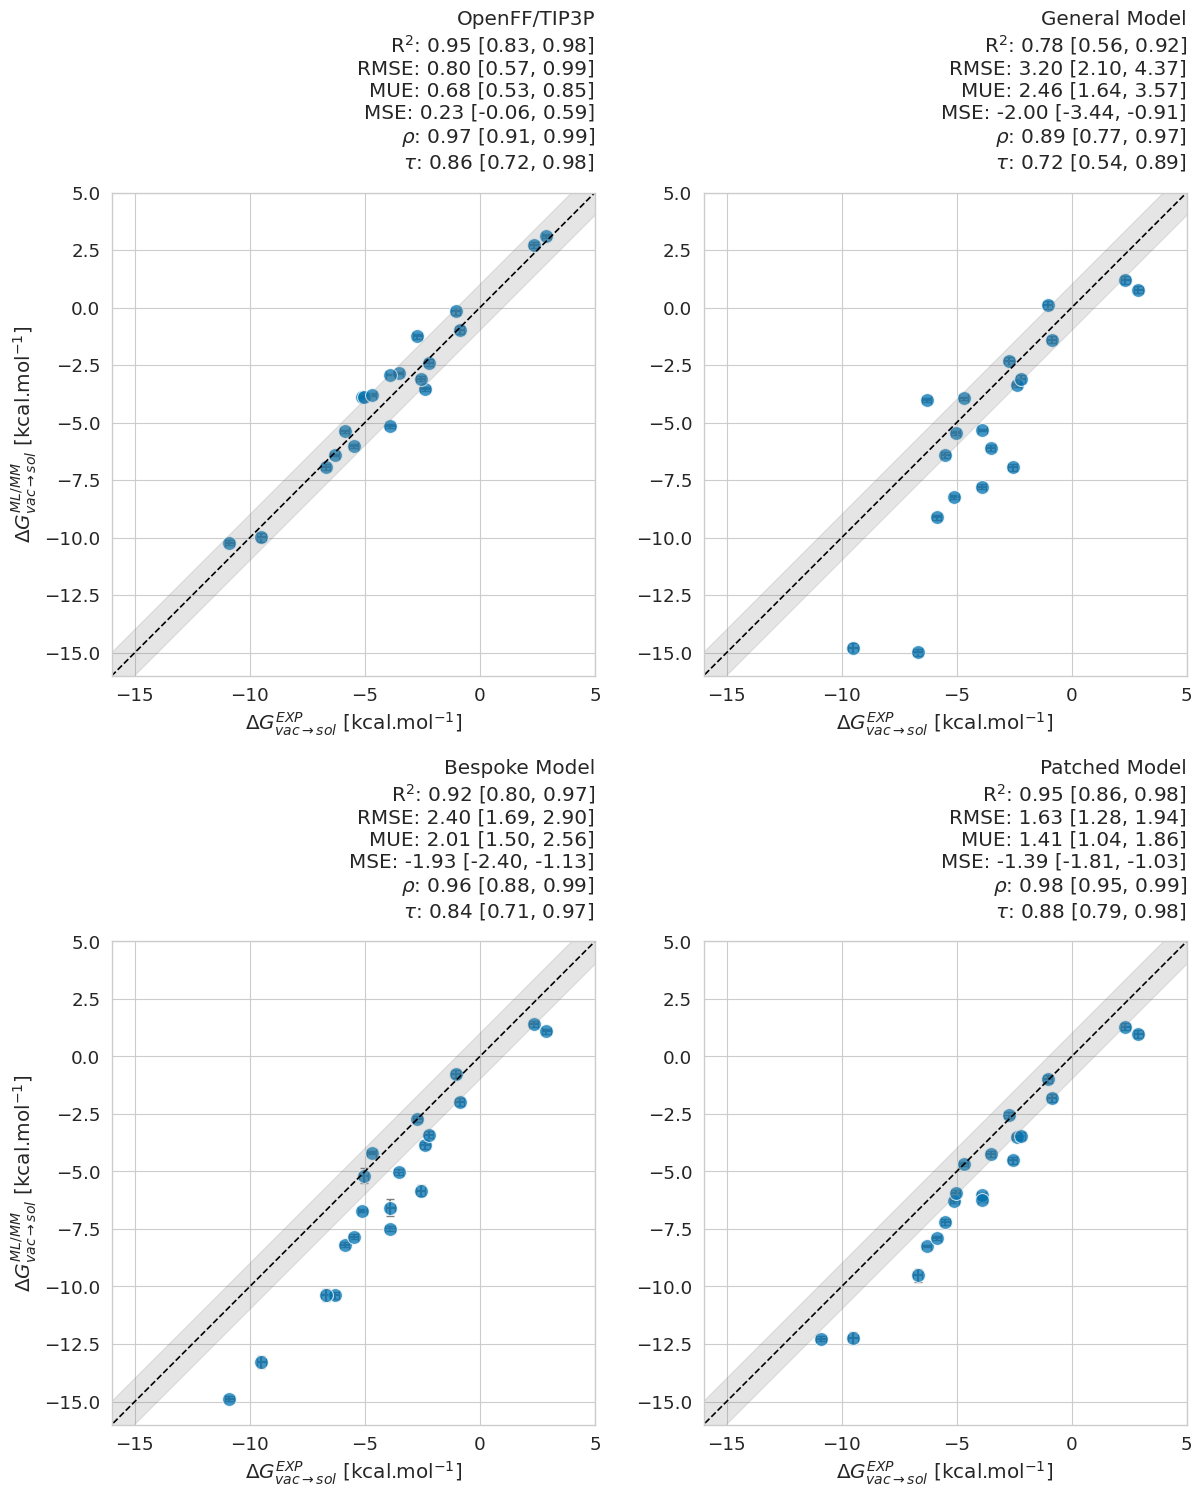

In [26]:
sns.set(style="whitegrid", palette="colorblind", context="paper", font_scale=1.5)

columns_to_plot = df_data_mean.columns[1:]
num_plots = len(columns_to_plot)
ncols = 2
nrows = (num_plots + ncols - 1) // ncols

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(14, 8 * nrows), sharex=False, sharey=False
)

axes = axes.flatten()

# Define y=x line
xx = np.linspace(-100, 100, 100)
yy = xx

for i, column in enumerate(columns_to_plot):
    x = df_data_mean["EXP"]
    y = df_data_mean[column]

    # Bootstrap statistics ['RMSE', 'MUE', 'R2', 'rho','KTAU','RAE']
    metrics = ["R2", "RMSE", "MUE", "MSE", "rho", "KTAU"]
    statistics = {}
    statistics_string = ""
    statistic_type = "mle"
    statistic_name = {
        "RMSE": r"RMSE",
        "MUE": r"MUE",
        "MSE": r"MSE",
        "R2": r"R$^2$",
        "rho": r"$\rho$",
        "KTAU": r"$\tau$",
    }
    for statistic in metrics:
        statistics[statistic] = bootstrap_statistic(x, y, statistic=statistic)
        s = statistics[statistic]
        string = (
            f"{statistic_name[statistic]}: {s[statistic_type]:.2f} [{s['low']:.2f}, {s['high']:.2f}]"
            + "\n"
        )
        statistics_string += string

    sns.lineplot(ax=axes[i], x=xx, y=yy, color="black", linestyle="--")
    sns.scatterplot(ax=axes[i], x=x, y=y, alpha=0.75, s=100)

    axes[i].errorbar(
        x,
        y,
        xerr=df_data_error["EXP"],
        yerr=df_data_error[column],
        fmt="none",  # no marker
        ecolor="gray",
        elinewidth=1.5,
        capsize=3,
        alpha=1.0,
        zorder=0,
    )
    # axes[i].set_title(f'{column}')
    if i in [0, 2]:
        axes[i].set_ylabel(
            r"$\Delta G^{ML/MM}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]"
        )
    else:
        axes[i].set_ylabel("")

    axes[i].set_xlabel(r"$\Delta G^{EXP}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]")

    small_dist = 1.0
    scale = np.linspace(-100, 100, 100)
    axes[i].fill_between(
        scale,
        scale - small_dist,
        scale + small_dist,
        color="grey",
        alpha=0.2,
    )

    axes[i].set_title(
        f"{column}\n{statistics_string}",
        loc="right",
        horizontalalignment="right",
        pad=1,
    )

    axes[i].grid(True)
    xmin = ymin = -16
    xmax = ymax = 5
    axes[i].set_xlim(xmin, xmax)
    axes[i].set_ylim(ymin, ymax)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


for ax in axes:
    ax.set_aspect("equal", "box")

# reduce vertical space between subplots
plt.subplots_adjust(hspace=0.55)
plt.savefig("ahfe_benchmark.pdf", bbox_inches="tight", dpi=300, transparent=True)
plt.show()